In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


## Carga de los datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ruta_csv = '/content/drive/MyDrive/Septimo ciclo/Mineria de datos/Proyecto/Mineria de datos/clips/audio_features_with_gender_and_age.csv'

# Cargar el dataset
df = pd.read_csv(ruta_csv)
print(f"\n✓ Dataset cargado correctamente")
print(f"Dimensiones: {df.shape}")
print(f"\nPrimeras filas:")
print(df.head())


Mounted at /content/drive

✓ Dataset cargado correctamente
Dimensiones: (2996, 45)

Primeras filas:
   mean_spectral_centroid  std_spectral_centroid  mean_spectral_bandwidth  \
0             2523.231827            1832.982941              1149.654083   
1             1542.213606            1001.261703              1316.990525   
2             2179.993253            1543.676335              1444.146313   
3             2301.647978            2046.331134              1019.403659   
4             2025.016079            1705.281012              1226.477797   

   std_spectral_bandwidth  mean_spectral_contrast  mean_spectral_flatness  \
0              526.589132               33.620332                0.055383   
1              641.044093               35.872289                0.014409   
2              675.637252               31.597122                0.117705   
3              636.872378               27.819356                0.408344   
4              738.085532               30.073968   

## Analisis exploratorio de los datos


ANÁLISIS EXPLORATORIO

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2996 entries, 0 to 2995
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean_spectral_centroid   2996 non-null   float64
 1   std_spectral_centroid    2996 non-null   float64
 2   mean_spectral_bandwidth  2996 non-null   float64
 3   std_spectral_bandwidth   2996 non-null   float64
 4   mean_spectral_contrast   2996 non-null   float64
 5   mean_spectral_flatness   2996 non-null   float64
 6   mean_spectral_rolloff    2996 non-null   float64
 7   zero_crossing_rate       2996 non-null   float64
 8   rms_energy               2996 non-null   float64
 9   mean_pitch               2996 non-null   float64
 10  min_pitch                2996 non-null   float64
 11  max_pitch                2996 non-null   float64
 12  std_pitch                2996 non-null   float64
 13  spectral_skew            2996

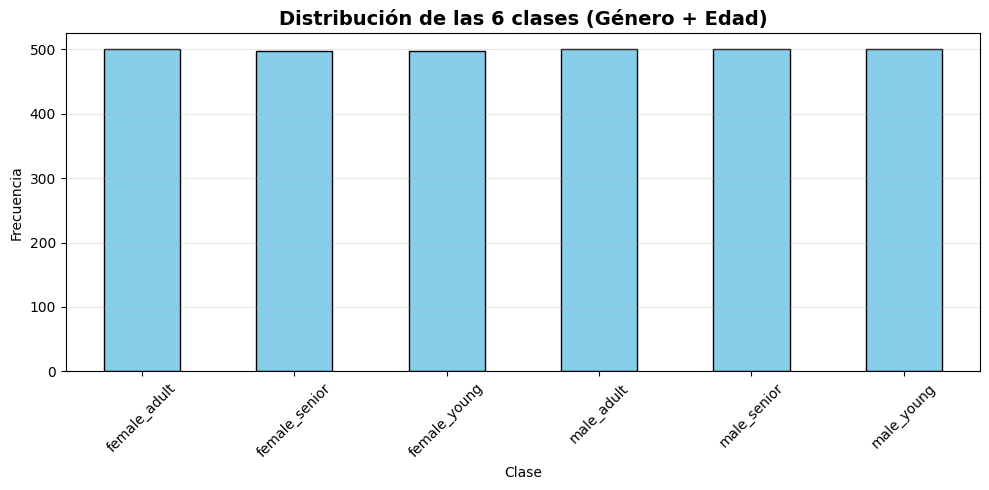

In [3]:
print("\n" + "="*80)
print("ANÁLISIS EXPLORATORIO")
print("="*80)

# Información del dataset
print("\nInformación del dataset:")
print(df.info())

print(f"\nValores nulos por columna:")
print(df.isnull().sum().sum())

print("\n--- Distribución por género ---")
print(df['gender'].value_counts())
print("\n--- Distribución por edad ---")
print(df['age'].value_counts())

df['gender_age'] = df['gender'] + '_' + df['age']
print("\n--- Distribución de las 6 clases combinadas ---")
print(df['gender_age'].value_counts().sort_index())

# Visualizar la distribución
plt.figure(figsize=(10, 5))
df['gender_age'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribución de las 6 clases (Género + Edad)', fontsize=14, fontweight='bold')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## Características a seleccionar

In [4]:
print("\n" + "="*80)
print("SELECCIÓN DE CARACTERÍSTICAS")
print("="*80)

caracteristicas_criticas = [
    # MFCC (1-13) - medias y desviaciones
    'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std',
    'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std',
    'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std',
    'mfcc_7_mean', 'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std',
    'mfcc_9_mean', 'mfcc_9_std', 'mfcc_10_mean', 'mfcc_10_std',
    'mfcc_11_mean', 'mfcc_11_std', 'mfcc_12_mean', 'mfcc_12_std',
    'mfcc_13_mean', 'mfcc_13_std',
    # Pitch (crítico para género)
    'mean_pitch', 'min_pitch', 'max_pitch', 'std_pitch',
    # Prosódicas
    'rms_energy', 'zero_crossing_rate',
    # Espectrales complementarias
    'mean_spectral_centroid', 'std_spectral_centroid',
    'mean_spectral_bandwidth', 'std_spectral_bandwidth',
    'mean_spectral_contrast', 'mean_spectral_rolloff',
    'mean_spectral_flatness'
]

caracteristicas_disponibles = [c for c in caracteristicas_criticas if c in df.columns]
print(f"\n✓ Características seleccionadas: {len(caracteristicas_disponibles)}")
print(f"Características principales: MFCC (26), Pitch (4), Prosódicas (2), Espectrales (7)")

# Separar características (X) y etiqueta (y)
X = df[caracteristicas_disponibles]
y = df['gender_age']

print(f"\nDimensiones finales:")
print(f"X (características): {X.shape}")
print(f"y (etiquetas): {y.shape}")


SELECCIÓN DE CARACTERÍSTICAS

✓ Características seleccionadas: 39
Características principales: MFCC (26), Pitch (4), Prosódicas (2), Espectrales (7)

Dimensiones finales:
X (características): (2996, 39)
y (etiquetas): (2996,)


## Codificación de etiquetas

In [5]:
print("\n" + "="*80)
print("CODIFICACIÓN DE ETIQUETAS")
print("="*80)

# Codificar las 6 clases a números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nMapeo de clases:")
for i, clase in enumerate(label_encoder.classes_):
    print(f"{i}: {clase}")


CODIFICACIÓN DE ETIQUETAS

Mapeo de clases:
0: female_adult
1: female_senior
2: female_young
3: male_adult
4: male_senior
5: male_young


## División de los datos de entrenamiento

In [6]:
print("\n" + "="*80)
print("DIVISIÓN DE DATOS (70% TRAIN / 30% TEST)")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.30,
    stratify=y_encoded,
    random_state=42
)

print(f"\n✓ División completada")
print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

# Verificar distribución estratificada
print("\nDistribución en conjunto de entrenamiento:")
unique, counts = np.unique(y_train, return_counts=True)
for clase, count in zip(unique, counts):
    print(f"  Clase {label_encoder.classes_[clase]}: {count} muestras")

print("\nDistribución en conjunto de prueba:")
unique, counts = np.unique(y_test, return_counts=True)
for clase, count in zip(unique, counts):
    print(f"  Clase {label_encoder.classes_[clase]}: {count} muestras")



DIVISIÓN DE DATOS (70% TRAIN / 30% TEST)

✓ División completada
Conjunto de entrenamiento: 2097 muestras
Conjunto de prueba: 899 muestras

Distribución en conjunto de entrenamiento:
  Clase female_adult: 350 muestras
  Clase female_senior: 348 muestras
  Clase female_young: 349 muestras
  Clase male_adult: 350 muestras
  Clase male_senior: 350 muestras
  Clase male_young: 350 muestras

Distribución en conjunto de prueba:
  Clase female_adult: 150 muestras
  Clase female_senior: 150 muestras
  Clase female_young: 149 muestras
  Clase male_adult: 150 muestras
  Clase male_senior: 150 muestras
  Clase male_young: 150 muestras


In [7]:
print("\n" + "="*80)
print("ESCALADO DE CARACTERÍSTICAS")
print("="*80)

# StandardScaler: normaliza a media=0 y desviación=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Características estandarizadas (media=0, std=1)")
print(f"\nEjemplo - Media antes del escalado: {X_train.mean().mean():.4f}")
print(f"Ejemplo - Media después del escalado: {X_train_scaled.mean():.4f}")



ESCALADO DE CARACTERÍSTICAS
✓ Características estandarizadas (media=0, std=1)

Ejemplo - Media antes del escalado: 407.7125
Ejemplo - Media después del escalado: 0.0000


In [8]:
print("\n" + "="*80)
print("BÚSQUEDA DE HIPERPARÁMETROS (GRID SEARCH)")
print("="*80)

# Definir el modelo SVM con kernel RBF
svm_model = SVC(random_state=42)

# Definir el grid de hiperparámetros (escala exponencial)
param_grid = {
    'C': [0.1, 1, 10, 100],           # Parámetro de regularización
    'gamma': [0.001, 0.01, 0.1, 1],   # Parámetro del kernel RBF
    'kernel': ['rbf']                  # Kernel gaussiano
}

print("\nParámetros a explorar:")
print(f"C (regularización): {param_grid['C']}")
print(f"Gamma (kernel RBF): {param_grid['gamma']}")

# Configurar validación cruzada estratificada (5-fold)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search con validación cruzada
print("\n⏳ Ejecutando Grid Search (esto puede tomar varios minutos)...")
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("\n✓ Grid Search completado")
print(f"\nMejores hiperparámetros encontrados:")
print(f"  C = {grid_search.best_params_['C']}")
print(f"  Gamma = {grid_search.best_params_['gamma']}")
print(f"  Kernel = {grid_search.best_params_['kernel']}")
print(f"\nMejor accuracy en validación cruzada: {grid_search.best_score_:.4f}")



BÚSQUEDA DE HIPERPARÁMETROS (GRID SEARCH)

Parámetros a explorar:
C (regularización): [0.1, 1, 10, 100]
Gamma (kernel RBF): [0.001, 0.01, 0.1, 1]

⏳ Ejecutando Grid Search (esto puede tomar varios minutos)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

✓ Grid Search completado

Mejores hiperparámetros encontrados:
  C = 10
  Gamma = 0.01
  Kernel = rbf

Mejor accuracy en validación cruzada: 0.9032


In [9]:
import joblib

print("\n" + "="*80)
print("ENTRENAMIENTO DEL MODELO FINAL")
print("="*80)

# Obtener el mejor modelo
best_svm = grid_search.best_estimator_

print("✓ Modelo SVM entrenado con los mejores hiperparámetros")
print(f"Número de vectores de soporte: {best_svm.n_support_}")
print(f"Total de vectores de soporte: {best_svm.n_support_.sum()}")

# Guardar el modelo entrenado
model_filename = 'svm_gender_age_classifier.joblib'
joblib.dump(best_svm, model_filename)
print(f"\n✓ Modelo guardado exitosamente como '{model_filename}'")


ENTRENAMIENTO DEL MODELO FINAL
✓ Modelo SVM entrenado con los mejores hiperparámetros
Número de vectores de soporte: [218 114 253 129  92  98]
Total de vectores de soporte: 904

✓ Modelo guardado exitosamente como 'svm_gender_age_classifier.joblib'


In [10]:
print("\n" + "="*80)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA")
print("="*80)

# Predicciones
y_pred = best_svm.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"\n📊 RESULTADOS FINALES:")
print(f"{'='*50}")
print(f"Accuracy (Exactitud):        {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score (Macro):            {f1_macro:.4f}")
print(f"F1-Score (Weighted):         {f1_weighted:.4f}")
print(f"{'='*50}")

print("\n📋 REPORTE DE CLASIFICACIÓN DETALLADO:\n")
target_names = label_encoder.classes_
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))



EVALUACIÓN EN CONJUNTO DE PRUEBA

📊 RESULTADOS FINALES:
Accuracy (Exactitud):        0.9155 (91.55%)
F1-Score (Macro):            0.9159
F1-Score (Weighted):         0.9159

📋 REPORTE DE CLASIFICACIÓN DETALLADO:

               precision    recall  f1-score   support

 female_adult     0.8552    0.8267    0.8407       150
female_senior     0.9793    0.9467    0.9627       150
 female_young     0.8125    0.8725    0.8414       149
   male_adult     0.9351    0.9600    0.9474       150
  male_senior     0.9931    0.9600    0.9763       150
   male_young     0.9267    0.9267    0.9267       150

     accuracy                         0.9155       899
    macro avg     0.9170    0.9154    0.9159       899
 weighted avg     0.9171    0.9155    0.9159       899




MATRIZ DE CONFUSIÓN


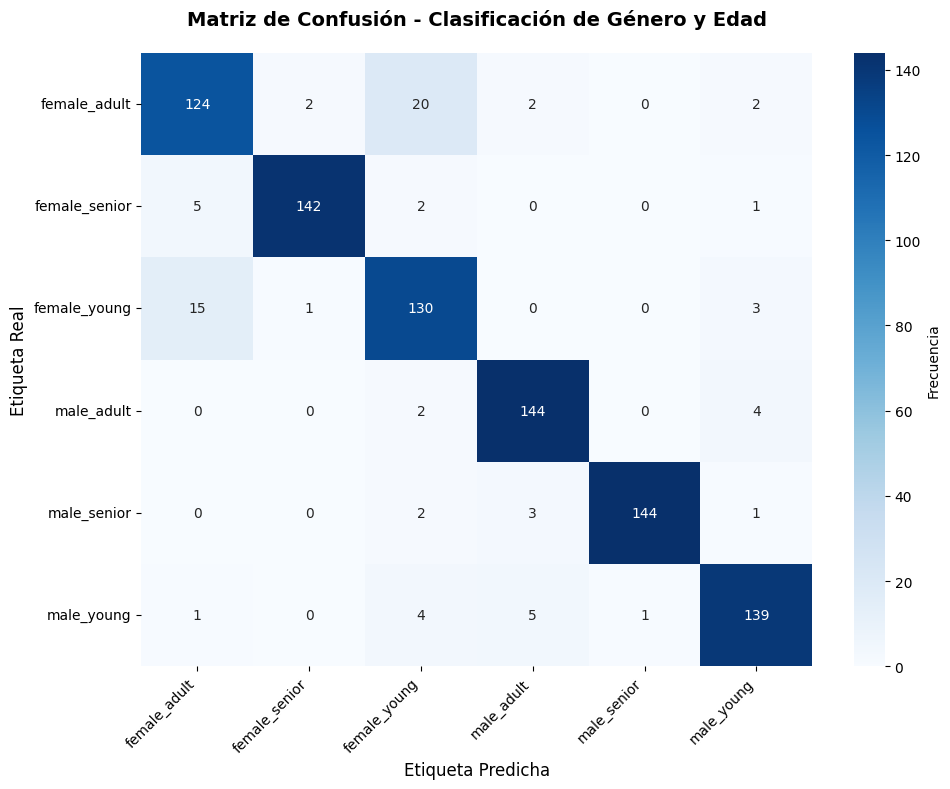


📊 Análisis de errores por clase:
female_adult        : 124/150 correctos (82.67% accuracy)
female_senior       : 142/150 correctos (94.67% accuracy)
female_young        : 130/149 correctos (87.25% accuracy)
male_adult          : 144/150 correctos (96.00% accuracy)
male_senior         : 144/150 correctos (96.00% accuracy)
male_young          : 139/150 correctos (92.67% accuracy)


In [11]:
print("\n" + "="*80)
print("MATRIZ DE CONFUSIÓN")
print("="*80)

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names,
            cbar_kws={'label': 'Frecuencia'})
plt.title('Matriz de Confusión - Clasificación de Género y Edad',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n📊 Análisis de errores por clase:")
for i, clase in enumerate(target_names):
    total_clase = cm[i].sum()
    correctos = cm[i][i]
    incorrectos = total_clase - correctos
    tasa_error = (incorrectos / total_clase) * 100 if total_clase > 0 else 0
    print(f"{clase:20s}: {correctos:3d}/{total_clase:3d} correctos ({100-tasa_error:.2f}% accuracy)")



ANÁLISIS DE CURVA DE APRENDIZAJE

⏳ Calculando curva de aprendizaje (esto puede tardar algunos minutos)...
✓ Curva de aprendizaje calculada


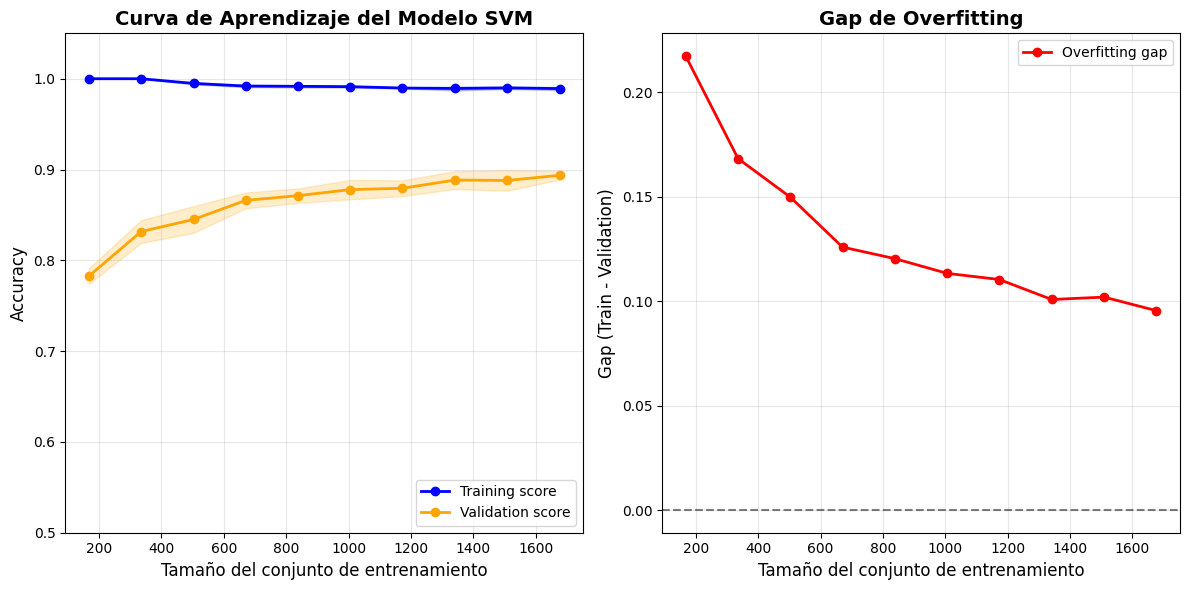


📊 ANÁLISIS DE LA CURVA DE APRENDIZAJE:
Con 100% de datos de entrenamiento:
  - Training accuracy:   0.9891 ± 0.0017
  - Validation accuracy: 0.8937 ± 0.0049
  - Gap (overfitting):   0.0955


In [12]:
print("\n" + "="*80)
print("ANÁLISIS DE CURVA DE APRENDIZAJE")
print("="*80)

from sklearn.model_selection import learning_curve

print("\n⏳ Calculando curva de aprendizaje (esto puede tardar algunos minutos)...")

# Calcular curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    best_svm,
    X_train_scaled,
    y_train,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 puntos desde 10% hasta 100% de datos
    scoring='accuracy',
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

print("✓ Curva de aprendizaje calculada")

plt.figure(figsize=(12, 6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation score', linewidth=2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')
plt.xlabel('Tamaño del conjunto de entrenamiento', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Curva de Aprendizaje del Modelo SVM', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.ylim([0.5, 1.05])

# Gráfico del gap entre train y validation
plt.subplot(1, 2, 2)
gap = train_mean - val_mean
plt.plot(train_sizes, gap, 'o-', color='red', linewidth=2, label='Overfitting gap')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Tamaño del conjunto de entrenamiento', fontsize=12)
plt.ylabel('Gap (Train - Validation)', fontsize=12)
plt.title('Gap de Overfitting', fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de la curva
print("\n📊 ANÁLISIS DE LA CURVA DE APRENDIZAJE:")
print(f"{'='*60}")
print(f"Con 100% de datos de entrenamiento:")
print(f"  - Training accuracy:   {train_mean[-1]:.4f} ± {train_std[-1]:.4f}")
print(f"  - Validation accuracy: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}")
print(f"  - Gap (overfitting):   {gap[-1]:.4f}")



ANÁLISIS DE IMPACTO DE HIPERPARÁMETROS

✓ Matriz de accuracy generada: (4, 4)


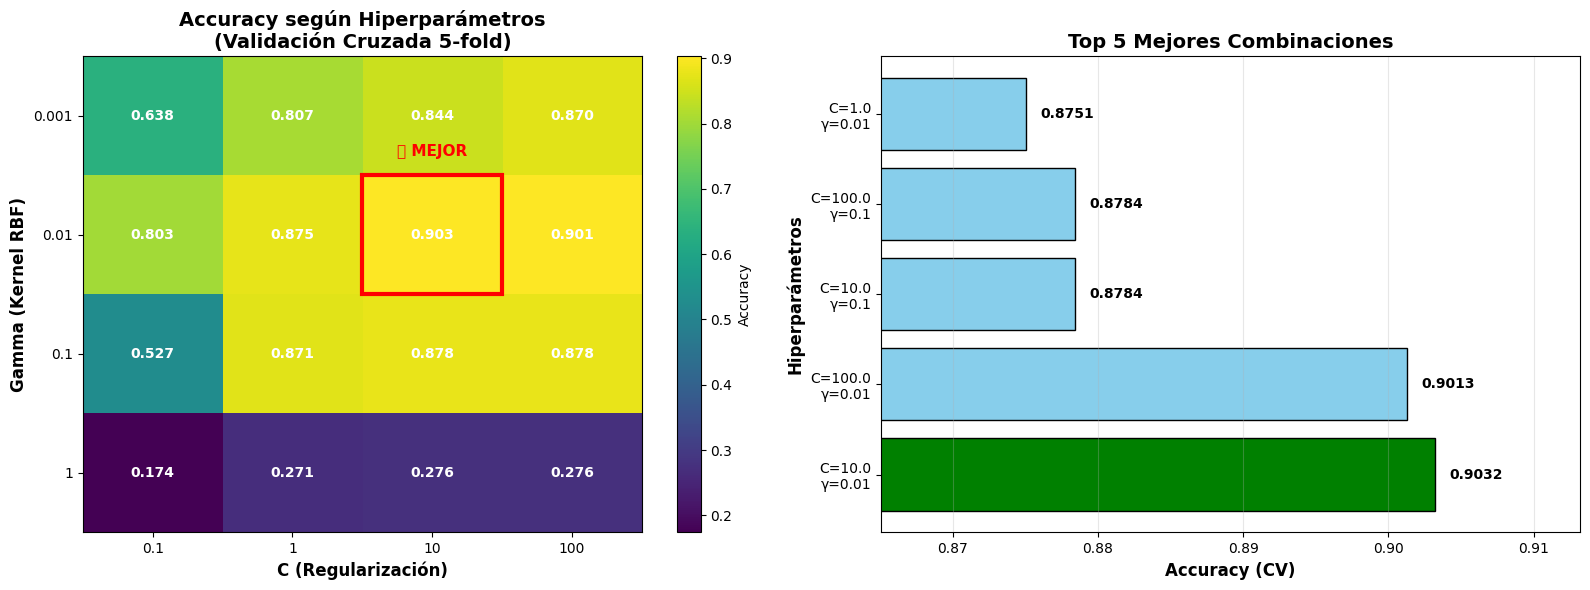


📊 ANÁLISIS DE IMPACTO DE HIPERPARÁMETROS:

Top 5 mejores combinaciones:
1. C=10.0, γ=0.01: 0.9032
2. C=100.0, γ=0.01: 0.9013
3. C=10.0, γ=0.1: 0.8784
4. C=100.0, γ=0.1: 0.8784
5. C=1.0, γ=0.01: 0.8751

📈 Sensibilidad de hiperparámetros:
  - Mejor accuracy:  0.9032
  - Peor accuracy:   0.1741
  - Rango de variación: 0.7291 (72.91%)


In [13]:
print("\n" + "="*80)
print("ANÁLISIS DE IMPACTO DE HIPERPARÁMETROS")
print("="*80)

# Extraer resultados del Grid Search
results = pd.DataFrame(grid_search.cv_results_)

# Crear matriz de resultados para C y gamma
C_values = param_grid['C']
gamma_values = param_grid['gamma']

# Crear matriz de accuracy
accuracy_matrix = np.zeros((len(gamma_values), len(C_values)))

for i, gamma in enumerate(gamma_values):
    for j, c in enumerate(C_values):
        mask = (results['param_C'] == c) & (results['param_gamma'] == gamma)
        accuracy_matrix[i, j] = results.loc[mask, 'mean_test_score'].values[0]

print(f"\n✓ Matriz de accuracy generada: {accuracy_matrix.shape}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))


im1 = axes[0].imshow(accuracy_matrix, cmap='viridis', aspect='auto')
axes[0].set_xticks(np.arange(len(C_values)))
axes[0].set_yticks(np.arange(len(gamma_values)))
axes[0].set_xticklabels(C_values)
axes[0].set_yticklabels(gamma_values)
axes[0].set_xlabel('C (Regularización)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Gamma (Kernel RBF)', fontsize=12, fontweight='bold')
axes[0].set_title('Accuracy según Hiperparámetros\n(Validación Cruzada 5-fold)',
                  fontsize=14, fontweight='bold')

# Añadir valores de accuracy en cada celda
for i in range(len(gamma_values)):
    for j in range(len(C_values)):
        text = axes[0].text(j, i, f'{accuracy_matrix[i, j]:.3f}',
                           ha="center", va="center", color="white", fontsize=10, fontweight='bold')

# Marcar el mejor valor
best_idx = np.unravel_index(accuracy_matrix.argmax(), accuracy_matrix.shape)
axes[0].add_patch(plt.Rectangle((best_idx[1]-0.5, best_idx[0]-0.5), 1, 1,
                                fill=False, edgecolor='red', lw=3))
axes[0].text(best_idx[1], best_idx[0]-0.7, '⭐ MEJOR',
            ha="center", va="center", color="red", fontsize=11, fontweight='bold')

plt.colorbar(im1, ax=axes[0], label='Accuracy')

# Gráfico de barras: Top 5 combinaciones
top_5_indices = results.nlargest(5, 'mean_test_score').index
top_5_params = []
top_5_scores = []

for idx in top_5_indices:
    c_val = results.loc[idx, 'param_C']
    gamma_val = results.loc[idx, 'param_gamma']
    score = results.loc[idx, 'mean_test_score']
    top_5_params.append(f'C={c_val}\nγ={gamma_val}')
    top_5_scores.append(score)

colors = ['green' if i == 0 else 'skyblue' for i in range(5)]
axes[1].barh(top_5_params, top_5_scores, color=colors, edgecolor='black')
axes[1].set_xlabel('Accuracy (CV)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Hiperparámetros', fontsize=12, fontweight='bold')
axes[1].set_title('Top 5 Mejores Combinaciones', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].set_xlim([min(top_5_scores) - 0.01, max(top_5_scores) + 0.01])


for i, (param, score) in enumerate(zip(top_5_params, top_5_scores)):
    axes[1].text(score + 0.001, i, f'{score:.4f}',
                va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


print("\n📊 ANÁLISIS DE IMPACTO DE HIPERPARÁMETROS:")
print(f"{'='*60}")
print(f"\nTop 5 mejores combinaciones:")
for i, (param, score) in enumerate(zip(top_5_params, top_5_scores), 1):
    print(f"{i}. {param.replace(chr(10), ', ')}: {score:.4f}")

# Análisis de sensibilidad
best_score = accuracy_matrix.max()
worst_score = accuracy_matrix.min()
sensitivity = best_score - worst_score

print(f"\n📈 Sensibilidad de hiperparámetros:")
print(f"  - Mejor accuracy:  {best_score:.4f}")
print(f"  - Peor accuracy:   {worst_score:.4f}")
print(f"  - Rango de variación: {sensitivity:.4f} ({sensitivity*100:.2f}%)")
